# Exploratory Analysis




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing important libraries

In [ ]:
%matplotlib inline
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as fig
import numpy as np
import matplotlib as mpl
import math, nltk, warnings
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import warnings; warnings.simplefilter('ignore')

In [ ]:
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [ ]:
def upload_mov(trace):
    data = pd.read_csv(trace)
    data['release_date'] = pd.to_datetime(data['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for variables in json_columns:
        data[variables] = data[variables].apply(json.loads)
    return data

In [ ]:
def upload_cred(trace):
    data = pd.read_csv(trace)
    json_columns = ['cast', 'crew']
    for variables in json_columns:
        data[variables] = data[variables].apply(json.loads)
    return data

In [ ]:
lost_variables = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'color',
    'cast_total_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'director_facebook_likes',
    'content_rating',
    'facenumber_in_poster',
    'num_critic_for_reviews',
    'movie_imdb_link',
    'movie_facebook_likes',
    'num_user_for_reviews']

In [ ]:
Conversion_t_to_i = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'revenue',
    'title': 'title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'keywords',
    'vote_count': 'num_voted_users'}

Remap = {'imdb_score': 'vote_average'}
#_____________________________________________________
def access(holder, index):
    given = holder
    try:
        for inx in index:
            given = given[inx]
        return given
    except IndexError or KeyError:
        return pd.np.nan
def director(crew_info):
    drects = [i['name'] for i in crew_info if i['job'] == 'Director']
    return access(drects, [0])
#_____________________________________________________
def pipe_flat_names(kake):
    return '|'.join([i['name'] for i in kake])
#_____________________________________________________
def convert_to_original_format(mie, cdr):
    t_mie = mie.copy()
    t_mie.rename(columns=Conversion_t_to_i, inplace=True)
    t_mie['title_year'] = pd.to_datetime(t_mie['release_date']).apply(lambda x: x.year)
    t_mie['country'] = t_mie['production_countries'].apply(lambda x: access(x, [0, 'name']))
    t_mie['language'] = t_mie['spoken_languages'].apply(lambda x: access(x, [0, 'name']))
    t_mie['director_name'] = cdr['crew'].apply(director)
    t_mie['actor_1_name'] = cdr['cast'].apply(lambda x: access(x, [1, 'name']))
    t_mie['actor_2_name'] = cdr['cast'].apply(lambda x: access(x, [2, 'name']))
    t_mie['actor_3_name'] = cdr['cast'].apply(lambda x: access(x, [3, 'name']))
    t_mie['genres'] = t_mie['genres'].apply(pipe_flat_names)
    t_mie['keywords'] = t_mie['keywords'].apply(pipe_flat_names)
    return t_mie

In [ ]:
cdr = upload_cred("/content/drive/MyDrive/tmdb_5000_credits.csv")
mie = upload_mov("/content/drive/MyDrive/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(mie, cdr)
print('Shape:',df_initial.shape)
table_value=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
table_value=table_value.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
table_value=table_value.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
table_value

Shape: (4803, 26)


,budget,genres,homepage,id,keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,duration,spoken_languages,status,tagline,title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0.0,0.0,64.355611,0.0,0.0,1.790548,0.0,0.062461,0.0,0.0,0.0,0.02082,0.0,0.041641,0.0,0.0,17.572351,0.0,0.0,0.0,0.02082,3.622736,0.62461,1.103477,1.31168,1.93629


In [ ]:
setting_kw = set()
for listing_kw in df_initial['keywords'].str.split('|').values:
    if isinstance(listing_kw, float): continue  
    setting_kw = setting_kw.union(listing_kw)
setting_kw.remove('')

In [ ]:
#Fucntion to count the occurence 
def word_quantity(data, reference, listing):
    kw_number = dict()
    for s in listing: kw_number[s] = 0
    for listing_kw in data[reference].str.split('|'):        
        if type(listing_kw) == float and pd.isnull(listing_kw): continue        
        for s in [s for s in listing_kw if s in listing]: 
            if pd.notnull(s): kw_number[s] += 1
    keyword_numbers = []
    for k,v in kw_number.items():
        keyword_numbers.append([k,v])
    keyword_numbers.sort(key = lambda x:x[1], reverse = True)
    return keyword_numbers, kw_number

In [ ]:
#Keywords and thei number of occurences
keyword_numbers, dum = word_quantity(df_initial, 'keywords', setting_kw)
keyword_numbers[:25]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189],
 ['aftercreditsstinger', 170],
 ['violence', 150],
 ['dystopia', 139],
 ['sport', 126],
 ['revenge', 118],
 ['sex', 111],
 ['friendship', 106],
 ['biography', 105],
 ['musical', 105],
 ['teenager', 99],
 ['3d', 98],
 ['love', 95],
 ['sequel', 94],
 ['suspense', 92],
 ['new york', 89],
 ['police', 84],
 ['los angeles', 81],
 ['high school', 80],
 ['alien', 76],
 ['prison', 72]]

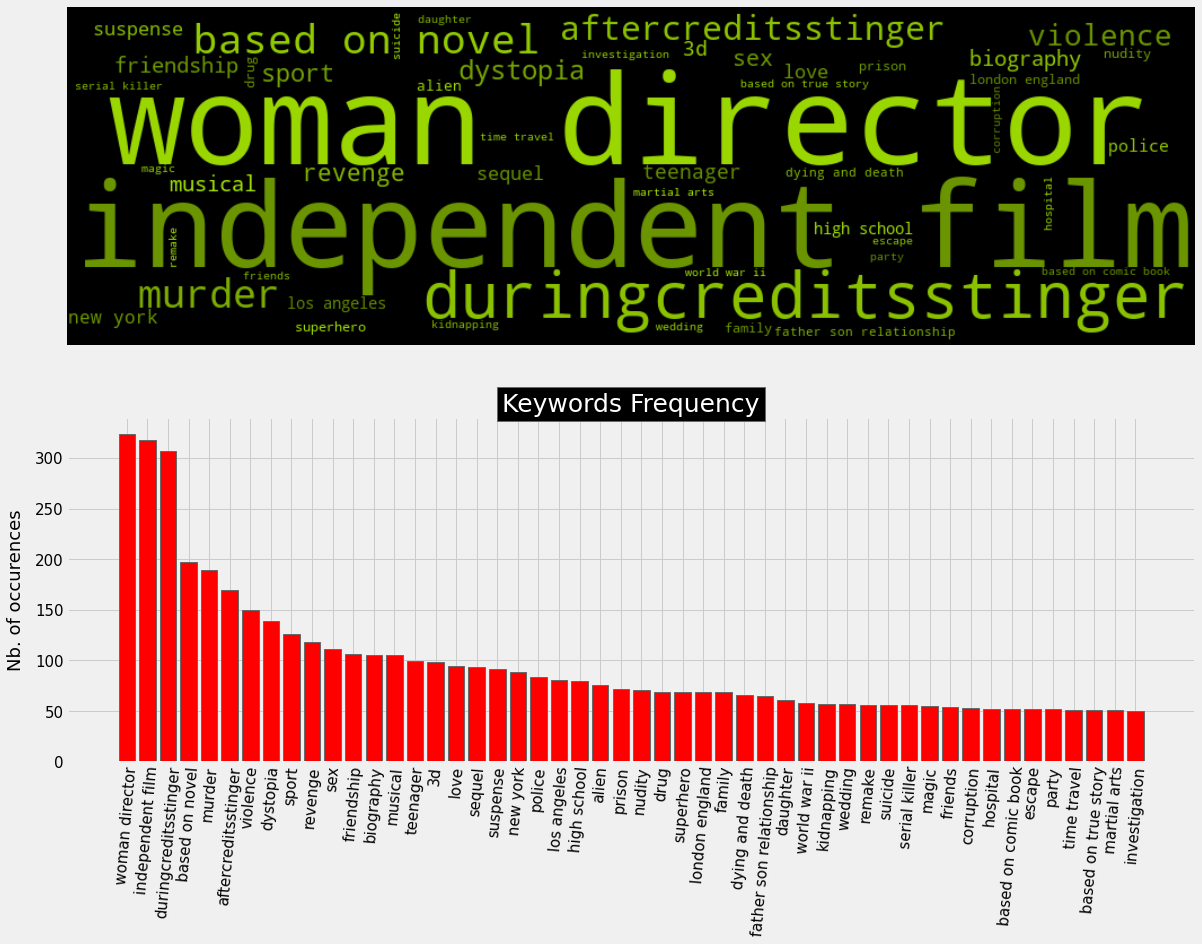

In [ ]:
def random_colour(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_numbers[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_colour,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
# HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
#_______________________
plt.title("Keywords Frequency",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

KEYWORDS AND THEIR FREQUENCIES 

In [ ]:

genres_inn = set()
for s in df_initial['genres'].str.split('|').values:
    genres_inn = genres_inn.union(set(s))

In [ ]:
keyword_numbers, dum = word_quantity(df_initial, 'genres', genres_inn)
keyword_numbers[:25]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894],
 ['Adventure', 790],
 ['Crime', 696],
 ['Science Fiction', 535],
 ['Horror', 519],
 ['Family', 513],
 ['Fantasy', 424],
 ['Mystery', 348],
 ['Animation', 234],
 ['History', 197],
 ['Music', 185],
 ['War', 144],
 ['Documentary', 110],
 ['Western', 82],
 ['Foreign', 34],
 ['', 28],
 ['TV Movie', 8]]

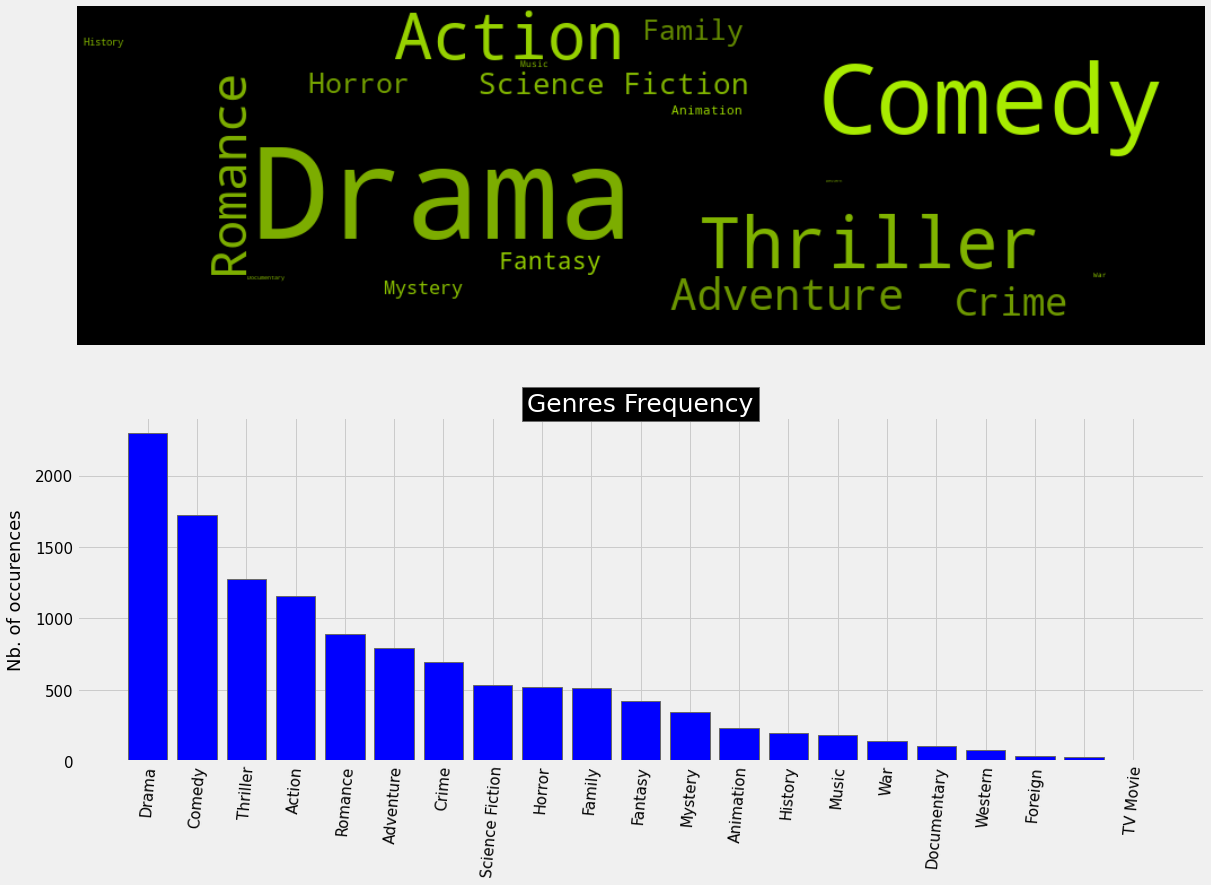

In [ ]:

fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_numbers[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_colour,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
#_______________________
plt.title("Genres Frequency",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

GENRES AND THEIR FREQUENICES 

In [ ]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)

def years(olo):
    return {'min':olo.min(),'max':olo.max(),'count': olo.count(),'mean':olo.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(years).unstack()

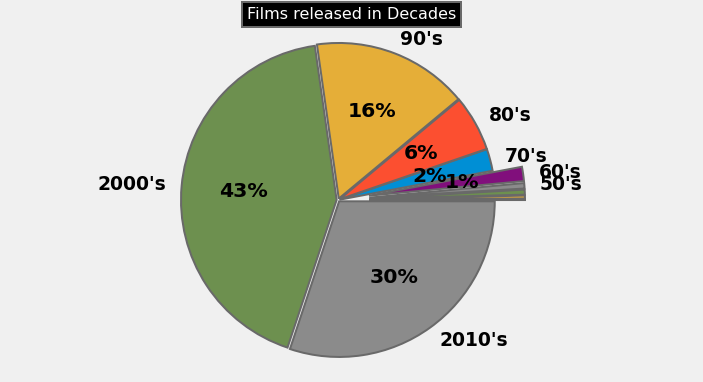

In [ ]:
sns.set_context("poster", font_scale=0.85)

def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('Films released in Decades',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

NUMBER OF FILMS PER DECADE AND ITS DISTRIBUTION

In [ ]:
df_initial.to_csv('full-movie-dataset.csv')